# Relatório Air Quality and Weather in Madrid

In [1]:
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

px.set_mapbox_access_token(open("ma_token").read())

## Variáveis globais

- wt-madrid: caminho para o arquivo com os dados meteorológicos
- aq-madrid: caminho para o arquivo com os dados de qualidade do ar

In [2]:
ARGS = {
    "wt-madrid": "dataset/extract/wt_madrid.h5",
    "aq-madrid": "dataset/extract/aq_madrid.h5",
}

## Funções

__describe_function__

Função que recebe um dataframe como entrada e gera um dataframe de saída com a descrição dos dados.

In [3]:
def describe_data(df: pd.DataFrame) -> pd.DataFrame:
    """This function describe the datas of a dataframe. Returning the max,
    min, mean, median, quantile, variance, standard deviation,
    mean absolute deviation, amplitude, root mean squared, kurtosis, skewness
    and count for all headers in dataframe

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe of input

    Returns
    -------
    pd.DataFrame
        Dataframe with the descriptions
    """

    FIRST_QUARTILE = 0.25
    THIRD_QUARTILE = 0.75
    IQR_CONSTANT = 1.5

    def _apply(header: str, column: []):
        _max = column.max()
        _min = column.min()

        # Scatter
        _q1 = column.quantile(FIRST_QUARTILE)
        _q3 = column.quantile(THIRD_QUARTILE)
        _iqr = _q3 - _q1
        _lower = max(_min, _q1 - (IQR_CONSTANT * _iqr))
        _upper = min(_max, _q3 + (IQR_CONSTANT * _iqr))

        return {
            "header": header,
            "max": _max,
            "min": _min,
            "mean": column.mean(),
            "median": column.median(),
            "lower limit": _lower,
            "1-quartile": _q1,
            "3-quartile": _q3,
            "upper limit": _upper,
            "var": column.var(),
            "std": column.std(),
            "mad": column.mad(),
            "amp": _max - _min,
            "rms": (column.pow(2)).mean() ** 0.5,
            "kurtosis": column.kurtosis(),
            "skew": column.skew(),
            "count": column.count(),
            "nans": column.isna().sum(),
        }

    return pd.DataFrame(
        [_apply(_, df.loc[:, _]) for _ in df.columns]
    ).set_index("header")

__corrplot__

Função que recebe um dataframe como entrada e gera o gráfico de correlação entre as variáveis.

In [4]:
def corrplot(df):
    """This function show correlation chart

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe of input
    """
    
    corr = df.corr('pearson', 1)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        _, ax1 = plt.subplots(1, 1, figsize=(18, 8))
        ax = sns.heatmap(
            corr,
            mask=mask,
            vmin=-1,
            vmax=1,
            annot=True,
            cmap='coolwarm',
            square=True,
            linewidths=.5,
            ax=ax1,
        )

## Datasets

### Weather Madrid 1997 - 2015

Dados do clima do aeroporto de Barajas, Madri, entre 1997 e 2015. Obtido em https://www.wunderground.com/ The Weather Company, LLC

Campos:
- Max TemperatureC
- Mean TemperatureC
- Min TemperatureC
- Dew PointC
- MeanDew PointC
- Min DewpointC
- Max Humidity
- Mean Humidity
- Min Humidity
- Max Sea Level PressurehPa
- Mean Sea Level PressurehPa
- Min Sea Level PressurehPa
- Max VisibilityKm
- Mean VisibilityKm
- Min VisibilitykM
- Max Wind SpeedKm/h
- Mean Wind SpeedKm/h
- Max Gust SpeedKm/h
- Precipitationmm
- CloudCover
- Events
- WindDirDegrees

Lê e exibe as chaves presentes em wt-madrid:

In [5]:
df_wt = pd.HDFStore(ARGS.get("wt-madrid"))
df_wt.keys()

['/master']

#### Pré-processamento

Filtra os dados no período de 2001 a 2015:

In [6]:
LOWER_LIMIT_DATE = "2001"

weather = df_wt.get("master")
weather = weather.set_index("CET")
weather = weather.sort_values("CET")
weather.index = pd.to_datetime(weather.index)
weather = weather[weather.index >= LOWER_LIMIT_DATE]

#### Análise exploratória

Os dados tratam-se de uma série temporal com a granularidade diária.

In [7]:
weather

,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,...,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
CET,,,,,,,,,,,,,,,,,,,,,
2001-01-01,10.0,7.0,4.0,9.0,6.0,3.0,100.0,89.0,81.0,1017,...,10.0,9.0,3.0,26,11,NaN,0.0,6.0,Rain,204
2001-01-10,10.0,7.0,3.0,9.0,6.0,3.0,100.0,98.0,87.0,1017,...,10.0,5.0,3.0,21,5,NaN,0.0,6.0,Rain,337
2001-01-11,11.0,8.0,5.0,9.0,7.0,5.0,100.0,90.0,76.0,1013,...,10.0,9.0,6.0,27,16,NaN,0.0,6.0,Rain,170
2001-01-12,9.0,7.0,6.0,7.0,6.0,4.0,100.0,93.0,81.0,1013,...,10.0,9.0,5.0,16,6,NaN,0.0,5.0,Rain,14
2001-01-13,12.0,6.0,1.0,5.0,3.0,0.0,100.0,78.0,58.0,1020,...,10.0,10.0,10.0,16,8,NaN,0.0,4.0,NaN,348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-05,27.0,20.0,12.0,10.0,7.0,3.0,67.0,42.0,14.0,1021,...,31.0,18.0,10.0,16,11,37.0,0.0,1.0,NaN,7
2015-09-06,28.0,21.0,15.0,11.0,8.0,5.0,63.0,40.0,16.0,1023,...,31.0,19.0,10.0,13,6,NaN,0.0,1.0,NaN,358
2015-09-07,27.0,21.0,16.0,13.0,9.0,3.0,68.0,46.0,15.0,1022,...,31.0,19.0,10.0,23,10,35.0,0.0,1.0,NaN,108


É observado presença de atributos:

- discretos:
 - Max Sea Level PressurehPa
 - Mean Sea Level PressurehPa
 - Min Sea Level PressurehPa
 - WindDirDegrees
- contínuos:
 - Max TemperatureC
 - Mean TemperatureC
 - Min TemperatureC
 - Dew PointC
 - MeanDew PointC
 - Min DewpointC
 - Max Humidity
 - Mean Humidity
 - Min Humidity
 - Max VisibilityKm
 - Mean VisibilityKm
 - Min VisibilitykM
 - Max Gust SpeedKm/h
 - Precipitationmm
 - CloudCover
- categóricos:
 - Events

In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5448 entries, 2001-01-01 to 2015-09-09
Data columns (total 22 columns):
Max TemperatureC               5446 non-null float64
Mean TemperatureC              5446 non-null float64
Min TemperatureC               5446 non-null float64
Dew PointC                     5446 non-null float64
MeanDew PointC                 5446 non-null float64
Min DewpointC                  5446 non-null float64
Max Humidity                   5446 non-null float64
 Mean Humidity                 5446 non-null float64
 Min Humidity                  5446 non-null float64
 Max Sea Level PressurehPa     5448 non-null int64
 Mean Sea Level PressurehPa    5448 non-null int64
 Min Sea Level PressurehPa     5448 non-null int64
 Max VisibilityKm              4686 non-null float64
 Mean VisibilityKm             4686 non-null float64
 Min VisibilitykM              4686 non-null float64
 Max Wind SpeedKm/h            5448 non-null int64
 Mean Wind SpeedKm/h           5448

Análise descritiva sobre os dados:

Através da função describe, é possível resumir os dados de forma que possibilite identificar o comportamento dos dados, como por exemplo:

- [1] Se os dados possuem uma distribuição normalizada (skew e kurtosis = 0). Nesse caso, grande parte dos dados possuem quase uma distribuição normal, com exceção de: Precipitationmm; Min VisibilitykM; Max Wind SpeedKm/h; e Mean VisibilityKm
- [2] A presença de valores ausentes em: Max Gust SpeedKm/h; CloudCover; e VisibilityKm

Em [1], também contribui para identificação da dispersão dos dados
Em [2], para alguns tipos de variáveis onde a quantidade de valores ausentes são pequenos, é possível corrigir com a técnica de interpolação, mas variáveis onde possuem um "gap" maior, talvez a interpolação prejudique a confiabilidade dos dados.

In [9]:
describe_data(weather.drop(" Events", axis=1))

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
Max TemperatureC,41.0,0.0,21.040947,20.0,0.0,13.0,29.00,41.0,80.283171,8.960088,7.772849,41.0,22.868972,-1.130591,0.147035,5446,2
Mean TemperatureC,31.0,-3.0,14.658649,14.0,-3.0,8.0,21.00,31.0,58.616057,7.656112,6.645929,34.0,16.537269,-1.076837,0.130431,5446,2
Min TemperatureC,26.0,-10.0,8.610356,9.0,-10.0,3.0,14.00,26.0,47.458067,6.888982,5.817300,36.0,11.026676,-0.911719,-0.047801,5446,2
Dew PointC,20.0,-12.0,7.932978,8.0,-4.0,5.0,11.00,20.0,22.447114,4.737839,3.778273,32.0,9.239867,0.144054,-0.471266,5446,2
MeanDew PointC,16.0,-15.0,4.764781,5.0,-7.0,2.0,8.00,16.0,21.740989,4.662723,3.740668,31.0,6.666344,0.302677,-0.486140,5446,2
Min DewpointC,14.0,-22.0,1.185090,1.0,-12.5,-2.0,5.00,14.0,24.289702,4.928458,3.924266,36.0,5.068499,0.520687,-0.422546,5446,2
Max Humidity,100.0,26.0,80.616783,87.0,26.5,67.0,94.00,100.0,321.339435,17.925943,15.323279,74.0,82.585387,-0.663000,-0.679028,5446,2
Mean Humidity,99.0,15.0,57.308667,58.0,15.0,40.0,74.00,99.0,401.066691,20.026650,17.248992,84.0,60.706477,-1.115221,-0.009115,5446,2
Min Humidity,93.0,4.0,33.729526,30.0,4.0,17.0,47.00,92.0,381.597905,19.534531,16.209607,89.0,38.977029,-0.364646,0.653752,5446,2


Exibição do gráfico de dipersão com informações das medidas de tendência central e separatrizes:

In [10]:
@interact(
    column=widgets.Dropdown(options=weather.columns, disabled=False)
)
def localplot(column):
    try:
        aux = weather.copy()
        fig = px.violin(
            x=aux.index.year,
            y=aux[column].values,
            box=True,
            points="all",
            title=f'Gráfico de dispersão de "{column}"',
            labels={"x": "data", "y": column}
        )
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='column', options=('Max TemperatureC', 'Mean TemperatureC', 'Min Te…

Gráfico de evolução

Aplicando o filtro sobre os atributos dos clima, é possível perceber que grande parte dessas variáveis possuem uma sazonalidade anual, onde os maiores "picos" são apresentados nos meses entre junho e agosto.

In [11]:
@interact(
    column=widgets.Dropdown(options=weather.columns, disabled=False)
)
def localplot(column):
    try:
        aux = weather.copy()
        aux = aux.groupby(aux.index.date).mean()
        fig = px.line(
            x=aux.index,
            y=aux[column].values,
            title=f'Gráfico de evolução de "{column}"',
            labels={"x": "data", "y": column}
        )
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='column', options=('Max TemperatureC', 'Mean TemperatureC', 'Min Te…

Gráfico de correlação:

As correlações que se destacam são:

- Positiva (> 0.5):
 - MeanDew PointC <-> Mean TemperatureC
 - CloudCover <-> Mean Humidity
- Negativa (< -0.5):
 - Mean Humidity <-> Mean TemperatureC

In [12]:
@interact(
    columns=widgets.SelectMultiple(options=weather.columns, disabled=False)
)
def localplot(columns):
    try:
        corrplot(weather[list(columns)])
    except Exception as e:
        print(e)

interactive(children=(SelectMultiple(description='columns', options=('Max TemperatureC', 'Mean TemperatureC', …

Visualização completa das correlações

In [13]:
@interact(
    columns=widgets.SelectMultiple(options=weather.columns, disabled=False)
)
def localplot(columns):
    fig = px.scatter_matrix(
        weather,
        dimensions=list(columns)
    )
    fig.show()

interactive(children=(SelectMultiple(description='columns', options=('Max TemperatureC', 'Mean TemperatureC', …

Exibição dos dados de direção e velocidade do vento utilizando rosa dos ventos:

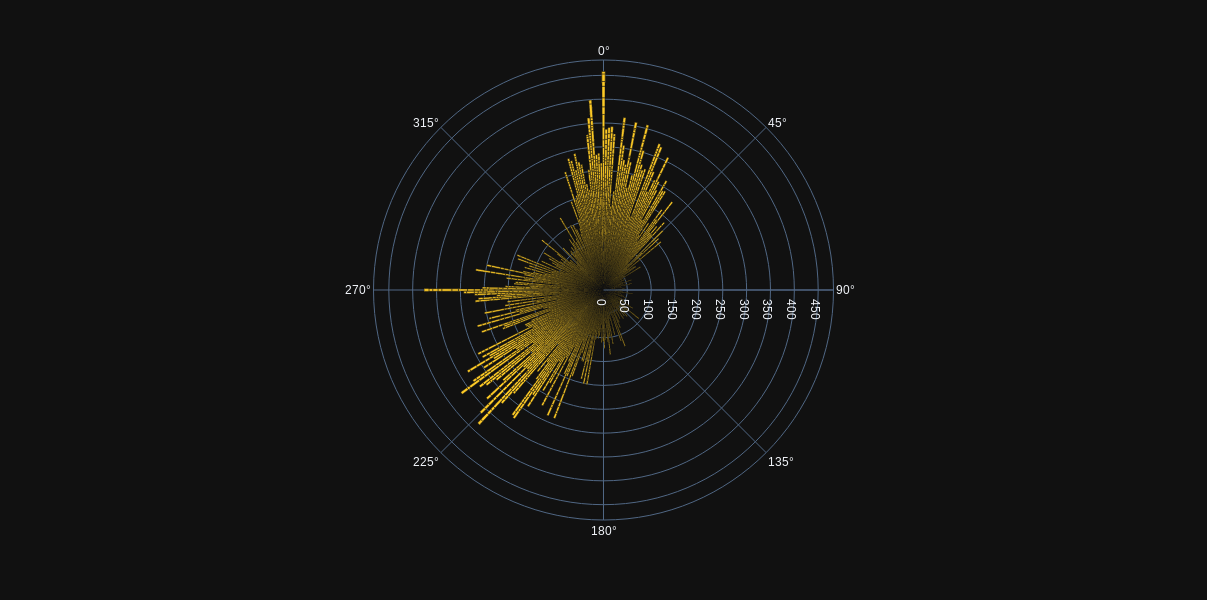

In [14]:
fig = px.bar_polar(
    weather,
    r=' Mean Wind SpeedKm/h',
    theta="WindDirDegrees",
    template="plotly_dark",
    color_discrete_sequence=px.colors.sequential.Plasma[-2::-1])
fig.show()

---

### Air Quality in Madrid (2001-2018)

Inclui dados históricos diário e horário dos níveis de qualidade do ar registrados de 2001 a 2018 e a lista das estações usadas para análise de poluição e outras particulas.

Fields:
- SO_2: sulphur dioxide level measured in μg/m³. High levels of sulphur dioxide can produce irritation in the skin and membranes, and worsen asthma or heart diseases in sensitive groups.
- CO: carbon monoxide level measured in mg/m³. Carbon monoxide poisoning involves headaches, dizziness and confusion in short exposures and can result in loss of consciousness, arrhythmias, seizures or even death in the long term.
- NO: nitric oxide level measured in μg/m³. This is a highly corrosive gas generated among others by motor vehicles and fuel burning processes.
- NO_2: nitrogen dioxide level measured in μg/m³. Long-term exposure is a cause of chronic lung diseases, and are harmful for the vegetation.
- PM25: particles smaller than 2.5 μm level measured in μg/m³. The size of these particles allow them to penetrate into the gas exchange regions of the lungs (alveolus) and even enter the arteries. Long-term exposure is proven to be related to low birth weight and high blood pressure in newborn babies.
- PM10: particles smaller than 10 μm. Even though the cannot penetrate the alveolus, they can still penetrate through the lungs and affect other organs. Long term exposure can result in lung cancer and cardiovascular complications
- NOx: nitrous oxides level measured in μg/m³. Affect the human respiratory system worsening asthma or other diseases, and are responsible of the yellowish-brown color of photochemical smog.
- O_3: ozone level measured in μg/m³. High levels can produce asthma, bronchytis or other chronic pulmonary diseases in sensitive groups or outdoor workers.
- TOL: toluene (methylbenzene) level measured in μg/m³. Long-term exposure to this substance (present in tobacco smkoke as well) can result in kidney complications or permanent brain damage.
- BEN: benzene level measured in μg/m³. Benzene is a eye and skin irritant, and long exposures may result in several types of cancer, leukaemia and anaemias. Benzene is considered a group 1 carcinogenic to humans by the IARC.
- EBE: ethylbenzene level measured in μg/m³. Long term exposure can cause hearing or kidney problems and the IARC has concluded that long-term exposure can produce cancer.
- MXY: m-xylene level measured in μg/m³. Xylenes can affect not only air but also water and soil, and a long exposure to high levels of xylenes can result in diseases affecting the liver, kidney and nervous system (especially memory and affected stimulus reaction).
- PXY: p-xylene level measured in μg/m³. See MXY for xylene exposure effects on health.
- OXY: o-xylene level measured in μg/m³. See MXY for xylene exposure effects on health.
- TCH: total hydrocarbons level measured in mg/m³. This group of substances can be responsible of different blood, immune system, liver, spleen, kidneys or lung diseases.
- CH4: methane level measured in mg/m³. This gas is an asphyxiant, which displaces the oxygen animals need to breath. Displaced oxygen can result in dizzinnes, weakness, nausea and loss of coordination.
- NMHC: non-methane hydrocarbons (volatile organic compounds) level measured in mg/m³. Long exposure to some of these substances can result in damage to the liver, kidney, and central nervous system. Some of them are suspected to cause cancer in humans.

Lê os dados de qualidade do ar e exibe as chaves (as chaves numéricas são os identificadores das estações):

In [15]:
df_aq = pd.HDFStore(ARGS.get("aq-madrid"))
df_aq.keys()

['/28079001',
 '/28079003',
 '/28079004',
 '/28079006',
 '/28079007',
 '/28079008',
 '/28079009',
 '/28079011',
 '/28079012',
 '/28079014',
 '/28079015',
 '/28079016',
 '/28079017',
 '/28079018',
 '/28079019',
 '/28079021',
 '/28079022',
 '/28079023',
 '/28079024',
 '/28079025',
 '/28079026',
 '/28079027',
 '/28079035',
 '/28079036',
 '/28079038',
 '/28079039',
 '/28079040',
 '/28079047',
 '/28079048',
 '/28079049',
 '/28079050',
 '/28079054',
 '/28079055',
 '/28079056',
 '/28079057',
 '/28079058',
 '/28079059',
 '/28079060',
 '/28079099',
 '/master']

#### Pré-processamento

Lista todas estações descritas no arquivo. Existem atributos:

- nominais:
 - name
 - address
- discretos:
 - id
 - elevation
- georreferenciado:
 - lon
 - lat

In [16]:
stations = df_aq.get("master")
stations

,id,name,address,lon,lat,elevation
0,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
1,28079008,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,-3.682319,40.421564,670
2,28079011,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,-3.677356,40.451475,708
3,28079016,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047,693
4,28079017,Villaverde,C/. Juan Peñalver,-3.713322,40.347139,604
5,28079018,Farolillo,Calle Farolillo - C/Ervigio,-3.731853,40.394781,630
6,28079024,Casa de Campo,Casa de Campo (Terminal del Teleférico),-3.747347,40.419356,642
7,28079027,Barajas Pueblo,"C/. Júpiter, 21 (Barajas)",-3.580031,40.476928,621
8,28079035,Pza. del Carmen,Plaza del Carmen esq. Tres Cruces.,-3.703172,40.419208,659
9,28079036,Moratalaz,Avd. Moratalaz esq. Camino de los Vinateros,-3.645306,40.407947,685


Exibição das estações no mapa:

In [17]:
fig = px.scatter_mapbox(
    stations,
    lat="lat",
    lon="lon",
    color="elevation",
    color_continuous_scale=px.colors.cmocean.turbid,
    hover_name="name",
    hover_data=["id"],
    zoom=10,
)
fig.show()

Filtra os dados no período de 2001 a 2015:

In [18]:
UPPER_LIMIT_DATE = "2016"
emissions = {}

try:
    for st in stations["id"]:
        aux = df_aq[str(st)]
        aux = aux.sort_values("date")
        emissions[st] = aux[aux.index < UPPER_LIMIT_DATE]
except Exception as e:
    print(f"[ERROR] {e}")
    df_aq.close()

#### Análise exploratória

Análise das informações presentes em uma estação específica:

- Possui granularidade horária
- Todos atributos (elementos químicos) são do tipo contínuo
- Existem valores ausentes

In [19]:
@interact(
    station=widgets.Dropdown(options=stations.id, disabled=False)
)
def localplot(station):
    st = stations[stations.id==station]
    display(
        f"Estação: {st.name.values} ({st.id.values}) "
        f"lat: {st.lat.values} lon: {st.lon.values} elev: {st.elevation.values} - "
        f"{st.address.values}",
        emissions[station]
    )

interactive(children=(Dropdown(description='station', options=(28079004, 28079008, 28079011, 28079016, 2807901…

Análise descritiva sobre os dados de cada estação:

In [20]:
@interact(
    station=widgets.Dropdown(options=stations.id, disabled=False)
)
def localplot(station):
    st = stations[stations.id==station]
    display(
        f"Estação: {st.name.values} ({st.id.values}) "
        f"lat: {st.lat.values} lon: {st.lon.values} elev: {st.elevation.values} - "
        f"{st.address.values}",
        describe_data(emissions[station])
    )

interactive(children=(Dropdown(description='station', options=(28079004, 28079008, 28079011, 28079016, 2807901…

Exibição do gráfico de dipersão com informações das medidas de tendência central e separatrizes:

In [21]:
station = widgets.Dropdown(options=stations.id, disabled=False)
variable = widgets.Select(options=emissions[station.value].columns, disabled=False)
@interact(station=station, variable=variable)
def localplot(station, variable):
    try:
        aux = emissions[station].copy()
        fig = px.violin(
            x=aux.index.year,
            y=aux[variable].values,
            box=True,
#             points="all", # comment to omit points
            title=f'Gráfico de dispersão de "{variable}"',
            labels={"x": "data", "y": variable}
        )
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='station', options=(28079004, 28079008, 28079011, 28079016, 2807901…

Gráfico de evolução

In [22]:
station = widgets.Dropdown(options=stations.id, disabled=False)
variables = widgets.SelectMultiple(options=emissions[station.value].columns, disabled=False)
@interact(station=station, variables=variables)
def localplot(station, variables):
    try:
        aux = emissions[station].copy()
        aux = aux.groupby(aux.index.date).mean() # comment for remove group date
        fig = px.line(
            x=aux.index,
            y=aux[variables[0]].values,
            title=f'Gráfico de evolução de "{station}"',
            labels={"x": "data", "y": "concentration", "name": variables[0]},
        )
        for var in range(1, len(variables)):
            fig.add_scatter(x=aux.index, y=aux[variables[var]].values, name=aux[variables[var]].name)
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='station', options=(28079004, 28079008, 28079011, 28079016, 2807901…

Gráfico de correlação

In [23]:
station = widgets.Dropdown(options=stations.id, disabled=False)
variables = widgets.SelectMultiple(options=emissions[station.value].columns, disabled=False)
@interact(station=station, variables=variables)
def localplot(station, variables):
    try:
        corrplot(emissions[station][list(variables)])
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='station', options=(28079004, 28079008, 28079011, 28079016, 2807901…

Visualização mais detalhada das correlações:

In [24]:
station = widgets.Dropdown(options=stations.id, disabled=False)
variables = widgets.SelectMultiple(options=emissions[station.value].columns, disabled=False)
@interact(station=station, variables=variables)
def localplot(station, variables):
    try:
        fig = px.scatter_matrix(
            emissions[station],
            dimensions=list(variables)
        )
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='station', options=(28079004, 28079008, 28079011, 28079016, 2807901…

---

### MISC

Concatenando dados da qualidade do ar:

In [25]:
misc = pd.DataFrame()
for st in emissions:
    aux = emissions[st].copy()
    aux["id"] = st
    misc = pd.concat([
        misc,
        pd.DataFrame(aux.groupby(aux.index.date).mean())],
        sort=True
    )
misc

,BEN,CH4,CO,EBE,MXY,NMHC,NO,NO_2,NOx,OXY,O_3,PM10,PM25,PXY,SO_2,TCH,TOL,id
2001-01-01,NaN,NaN,0.809565,NaN,NaN,NaN,NaN,57.817391,104.657392,NaN,18.357826,17.198261,NaN,NaN,16.983044,NaN,NaN,28079004
2001-01-02,NaN,NaN,0.447500,NaN,NaN,NaN,NaN,59.175417,70.984583,NaN,33.989167,12.267917,NaN,NaN,14.582500,NaN,NaN,28079004
2001-01-03,NaN,NaN,0.587917,NaN,NaN,NaN,NaN,64.322501,95.897083,NaN,22.037083,17.280000,NaN,NaN,14.847916,NaN,NaN,28079004
2001-01-04,NaN,NaN,0.523750,NaN,NaN,NaN,NaN,63.090416,90.787917,NaN,24.192083,17.016667,NaN,NaN,14.651667,NaN,NaN,28079004
2001-01-05,NaN,NaN,1.011250,NaN,NaN,NaN,NaN,57.421250,150.400833,NaN,9.684167,22.825417,NaN,NaN,16.221250,NaN,NaN,28079004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,NaN,NaN,NaN,NaN,NaN,NaN,4.375000,34.666667,NaN,NaN,50.000000,11.750000,NaN,NaN,NaN,NaN,NaN,28079060
2015-12-28,NaN,NaN,NaN,NaN,NaN,NaN,13.478261,50.695652,NaN,NaN,40.863636,20.208333,NaN,NaN,NaN,NaN,NaN,28079060
2015-12-29,NaN,NaN,NaN,NaN,NaN,NaN,20.083333,41.875000,NaN,NaN,44.500000,13.583333,NaN,NaN,NaN,NaN,NaN,28079060
2015-12-30,NaN,NaN,NaN,NaN,NaN,NaN,12.541667,41.458333,NaN,NaN,44.375000,10.416667,NaN,NaN,NaN,NaN,NaN,28079060


Análise descritiva dos dados:

In [26]:
describe_data(misc)

/opt/anaconda/envs/aqw-madrid-data-analysis/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning:

Mean of empty slice



,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
BEN,1.733792e+01,0.0,8.971050e-01,5.527083e-01,0.000000e+00,2.641667e-01,1.154167e+00,2.489167e+00,0.979672,0.989784,0.665430,17.337917,1.335824e+00,22.013830,3.405736,22326,68297
CH4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,90623
CO,7.640833e+00,0.0,4.927289e-01,3.937500e-01,0.000000e+00,2.725000e-01,6.033333e-01,1.099583e+00,0.121390,0.348411,0.238038,7.640833,6.034647e-01,16.540589,2.908764,57416,33207
EBE,4.032292e+01,0.0,1.100384e+00,8.250000e-01,0.000000e+00,4.958333e-01,1.262500e+00,2.412500e+00,1.316410,1.147349,0.691620,40.322917,1.589716e+00,133.130009,6.581398,22144,68479
MXY,4.082917e+01,0.0,3.458246e+00,2.112500e+00,0.000000e+00,1.007292e+00,4.553750e+00,9.873438e+00,13.254415,3.640661,2.560002,40.829167,5.021092e+00,11.333043,2.680555,5256,85367
NMHC,1.670417e+00,0.0,1.923207e-01,1.662500e-01,0.000000e+00,1.104167e-01,2.433333e-01,4.427083e-01,0.016223,0.127370,0.088791,1.670417,2.306722e-01,12.558347,2.503440,24184,66439
NO,3.791250e+02,1.0,2.396247e+01,1.075000e+01,1.000000e+00,4.625000e+00,2.704167e+01,6.066667e+01,1197.207317,34.600684,22.402189,378.125000,4.208776e+01,12.430075,3.081990,43769,46854
NO_2,1.864000e+02,0.0,4.514008e+01,4.204062e+01,0.000000e+00,2.799313e+01,5.908333e+01,1.057186e+02,523.460668,22.879263,18.239099,186.399999,5.060713e+01,0.673313,0.767483,90518,105
NOx,8.119333e+02,0.0,9.018659e+01,7.160583e+01,0.000000e+00,4.550052e+01,1.138865e+02,2.164654e+02,4469.303257,66.852848,48.025071,811.933334,1.122623e+02,6.971619,2.106394,46772,43851


Resetando índice (data) para mesclar com as estações

In [27]:
misc = misc.reset_index()
misc

,index,BEN,CH4,CO,EBE,MXY,NMHC,NO,NO_2,NOx,OXY,O_3,PM10,PM25,PXY,SO_2,TCH,TOL,id
0,2001-01-01,NaN,NaN,0.809565,NaN,NaN,NaN,NaN,57.817391,104.657392,NaN,18.357826,17.198261,NaN,NaN,16.983044,NaN,NaN,28079004
1,2001-01-02,NaN,NaN,0.447500,NaN,NaN,NaN,NaN,59.175417,70.984583,NaN,33.989167,12.267917,NaN,NaN,14.582500,NaN,NaN,28079004
2,2001-01-03,NaN,NaN,0.587917,NaN,NaN,NaN,NaN,64.322501,95.897083,NaN,22.037083,17.280000,NaN,NaN,14.847916,NaN,NaN,28079004
3,2001-01-04,NaN,NaN,0.523750,NaN,NaN,NaN,NaN,63.090416,90.787917,NaN,24.192083,17.016667,NaN,NaN,14.651667,NaN,NaN,28079004
4,2001-01-05,NaN,NaN,1.011250,NaN,NaN,NaN,NaN,57.421250,150.400833,NaN,9.684167,22.825417,NaN,NaN,16.221250,NaN,NaN,28079004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90618,2015-12-27,NaN,NaN,NaN,NaN,NaN,NaN,4.375000,34.666667,NaN,NaN,50.000000,11.750000,NaN,NaN,NaN,NaN,NaN,28079060
90619,2015-12-28,NaN,NaN,NaN,NaN,NaN,NaN,13.478261,50.695652,NaN,NaN,40.863636,20.208333,NaN,NaN,NaN,NaN,NaN,28079060
90620,2015-12-29,NaN,NaN,NaN,NaN,NaN,NaN,20.083333,41.875000,NaN,NaN,44.500000,13.583333,NaN,NaN,NaN,NaN,NaN,28079060
90621,2015-12-30,NaN,NaN,NaN,NaN,NaN,NaN,12.541667,41.458333,NaN,NaN,44.375000,10.416667,NaN,NaN,NaN,NaN,NaN,28079060


Concatenando dados da qualidade do ar com as informações georreferenciadas e recuperando índice:

In [28]:
misc = pd.merge(left=misc, right=stations, left_on='id', right_on='id')
misc = misc.set_index("index")
misc.index = pd.to_datetime(misc.index)
misc

,BEN,CH4,CO,EBE,MXY,NMHC,NO,NO_2,NOx,OXY,...,PXY,SO_2,TCH,TOL,id,name,address,lon,lat,elevation
index,,,,,,,,,,,,,,,,,,,,,
2001-01-01,NaN,NaN,0.809565,NaN,NaN,NaN,NaN,57.817391,104.657392,NaN,...,NaN,16.983044,NaN,NaN,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
2001-01-02,NaN,NaN,0.447500,NaN,NaN,NaN,NaN,59.175417,70.984583,NaN,...,NaN,14.582500,NaN,NaN,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
2001-01-03,NaN,NaN,0.587917,NaN,NaN,NaN,NaN,64.322501,95.897083,NaN,...,NaN,14.847916,NaN,NaN,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
2001-01-04,NaN,NaN,0.523750,NaN,NaN,NaN,NaN,63.090416,90.787917,NaN,...,NaN,14.651667,NaN,NaN,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
2001-01-05,NaN,NaN,1.011250,NaN,NaN,NaN,NaN,57.421250,150.400833,NaN,...,NaN,16.221250,NaN,NaN,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,NaN,NaN,NaN,NaN,NaN,NaN,4.375000,34.666667,NaN,NaN,...,NaN,NaN,NaN,NaN,28079060,Tres Olivos,Plaza Tres Olivos,-3.689761,40.500589,715
2015-12-28,NaN,NaN,NaN,NaN,NaN,NaN,13.478261,50.695652,NaN,NaN,...,NaN,NaN,NaN,NaN,28079060,Tres Olivos,Plaza Tres Olivos,-3.689761,40.500589,715
2015-12-29,NaN,NaN,NaN,NaN,NaN,NaN,20.083333,41.875000,NaN,NaN,...,NaN,NaN,NaN,NaN,28079060,Tres Olivos,Plaza Tres Olivos,-3.689761,40.500589,715


Exibindo mapa interativo

In [29]:
station = widgets.Dropdown(options=stations.id, disabled=False)
variable = widgets.Select(options=emissions[station.value].columns, disabled=False)
@interact(station=station, variable=variable)
def localplot(station, variable):
    aq = pd.DataFrame()
    for st in emissions:
        aux = emissions[st].copy()
        aux["id"] = st
        aq = pd.concat([
            aq,
            pd.DataFrame(aux.groupby(aux.index.year).mean())],
            sort=True
        )
    aq = aq.reset_index()
    aq = aq.rename({"index": "date"})
    aq = pd.merge(left=aq, right=stations, left_on='id', right_on='id')
    
    fig = px.scatter_mapbox(
        aq.fillna(0),
        lat="lat",
        lon="lon",
        color=variable,
        size=variable,
        animation_frame="date",
        color_continuous_scale=px.colors.sequential.solar,
        zoom=10
    )
    fig.show()

interactive(children=(Dropdown(description='station', options=(28079004, 28079008, 28079011, 28079016, 2807901…

developed by: patricksferraz | [github](https://github.com/patricksferraz)